In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap

#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_biogrid_lncrna2target_lncrinter.train.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.process_genes_info()

# READ Edgeslist
# network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/lmn_l08_m08_l08__correlation_node_similarity.edgelist", 
#                              is_directed=True)

In [3]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_mirtarbase_biogrid_lncrna2target.test.pickle', 'rb') as file:
    network_val = pickle.load(file)
#     network_val.process_genes_info()

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

In [5]:
import pickle
with open('moge/data/luad_data_multi_U-T.pickle', 'rb') as file:
    luad_data = pickle.load(file)
    network.multi_omics_data = luad_data
    network_val.multi_omics_data = luad_data
    network.process_genes_info()
    network_val.process_genes_info()

Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: -5169
Total nodes (filtered): 27514
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'GO Terms', 'Family']
Number of nodes without seq removed: -5950
Total nodes (filtered): 26733


In [5]:
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if d["type"]=="u" or d["type"]=="u_n"])

# Data Visualization

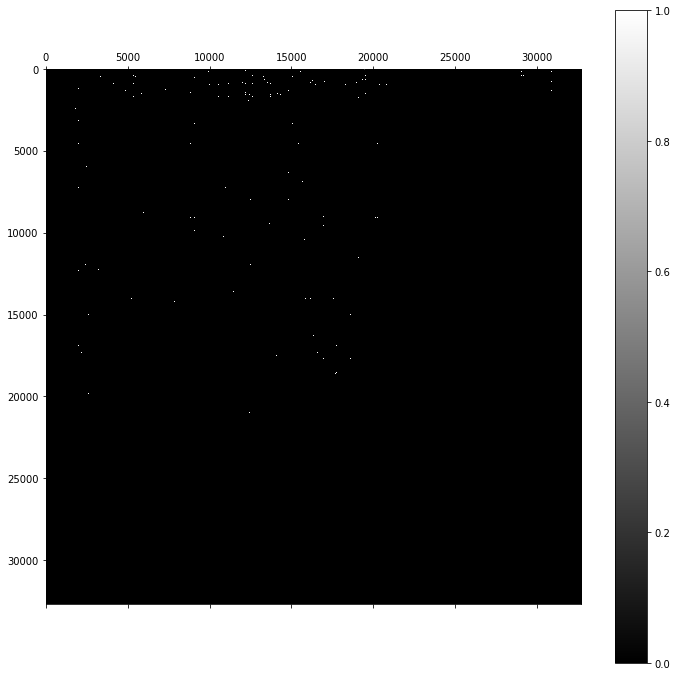

In [4]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

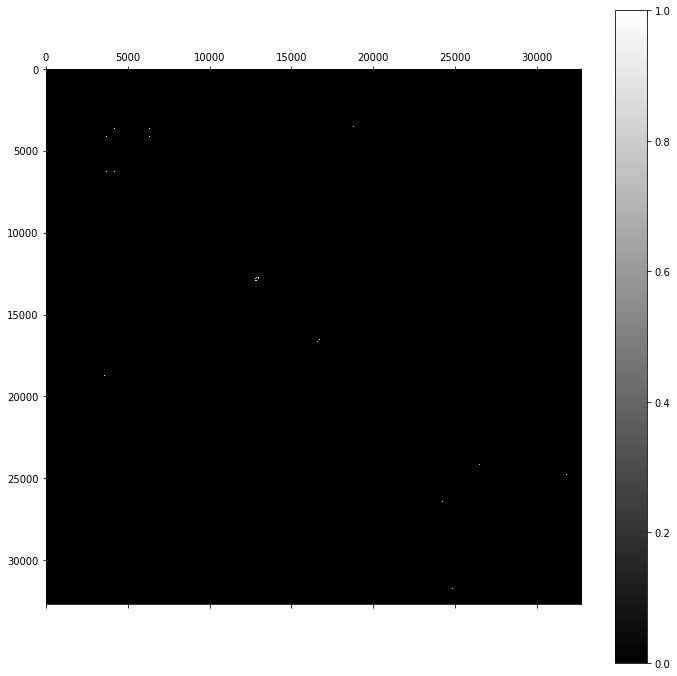

In [5]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

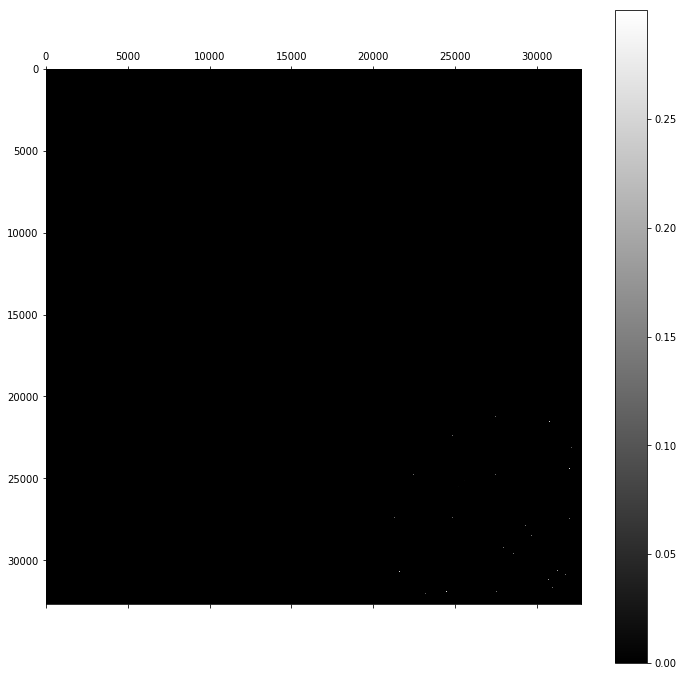

In [6]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

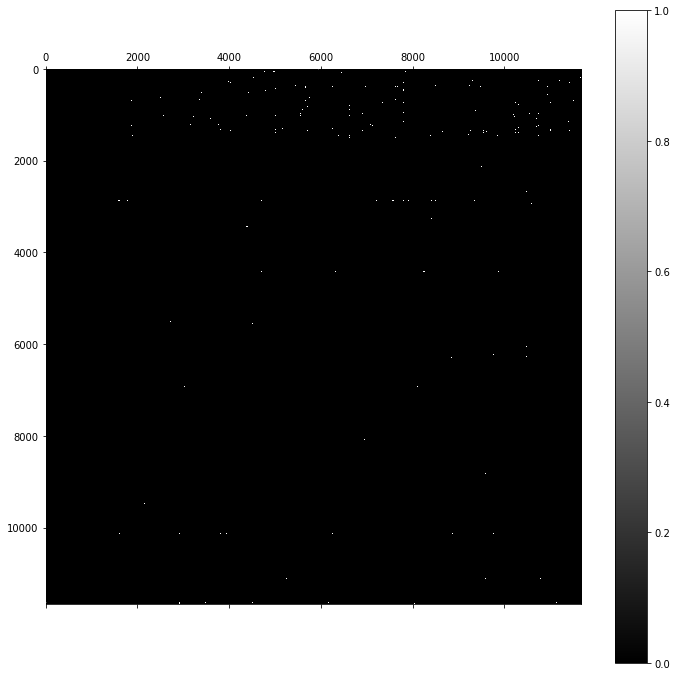

In [7]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [8]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding

siamese = SiameseGraphEmbedding(d=128, batch_size=2048, lr=0.001, epochs=20, negative_sampling_ratio=2.0,
                                 max_length=2000, truncating="random", verbose=True)

Using TensorFlow backend.


In [9]:
siamese.learn_embedding(network, network_val=network_val, multi_gpu=True, 
                        subsample=False, directed_proba=0.5, n_steps=2000, validation_steps=None, compression_func="log",
                        seed=2)

Ed_count: 583342 , Eu_count: 95126 , En_count: 444392
Ens_count: 1166684
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}
Ed_count: 88412 , Eu_count: 0 , En_count: 0
Ens_count: 176824
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}
Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 4), dtype=float32, device=/device:CPU:0)
conv2D Tensor("lambda_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
conv1d_2 Tensor("conv1d_1/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:CPU:0)
embedding Tensor("dense_3/BiasAdd:0", shape=(?, 128), dtype=float32, device=/device:CPU:0)
Instructions for updating:
Please switch to tf.metrics.auc. Note that the order 

# Visualize Embeddings

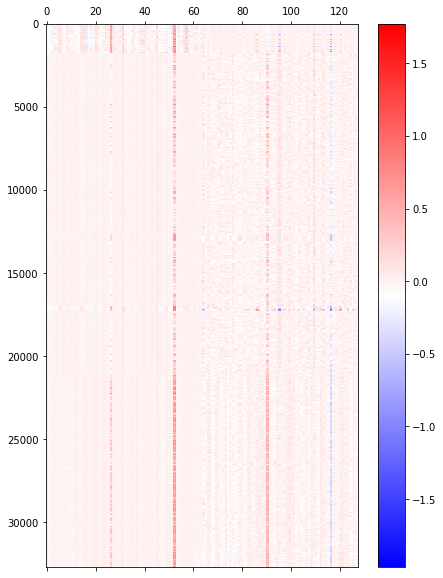

In [10]:
matrix_heatmap(siamese.get_embedding(), cmap="bwr", aspect='auto', figsize=(7,10))

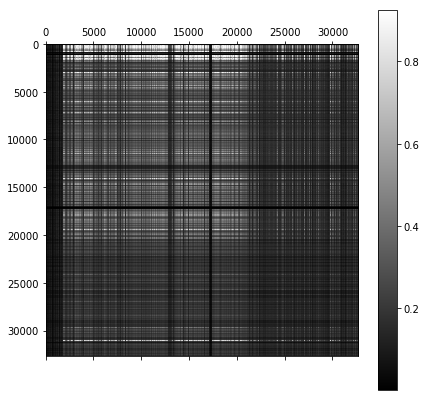

In [11]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=network.node_list), figsize=(7,7))

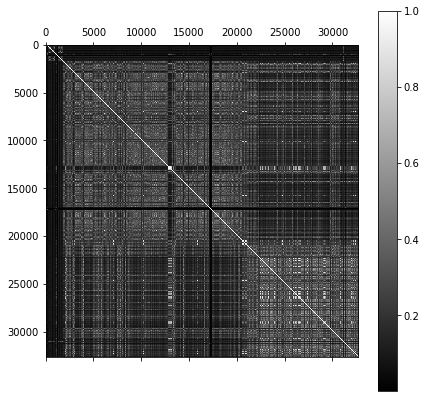

In [12]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u"), figsize=(7,7))

# Plot measures on training and testing

dict_keys(['val_loss', 'val_accuracy_d', 'val_precision_d', 'val_recall_d', 'val_auc_roc_d', 'loss', 'accuracy_d', 'precision_d', 'recall_d', 'auc_roc_d'])


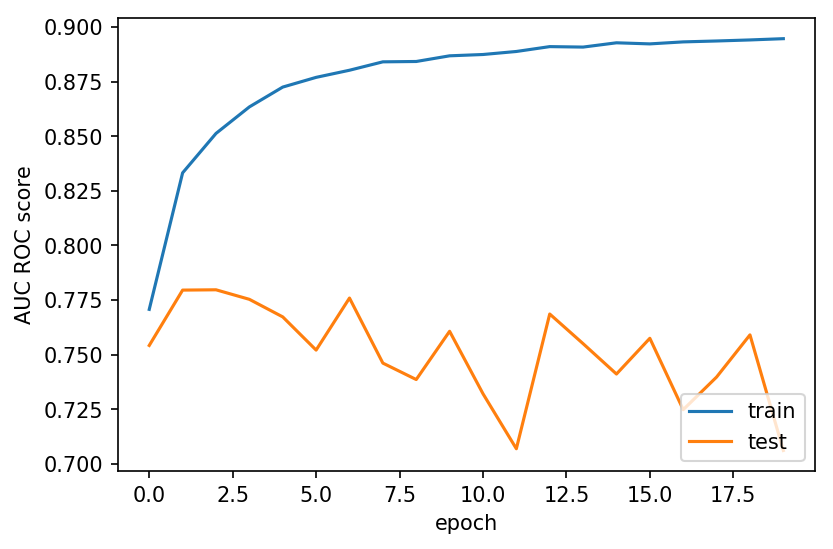

In [13]:
import matplotlib.pyplot as plt
history = siamese.history
print(history.history.keys())
plt.figure(dpi=150)
plt.plot(history.history['accuracy_d'])
plt.plot(history.history['val_accuracy_d'])
# plt.title('Link prediction performance')
plt.ylabel('AUC ROC score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Save Model & Embedding

In [99]:
siamese.lstm_network.save("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lstm_128.randtrunc.multi_seq_UT.biogrid.full.euclidean.e20.model.h5")
# siamese.alpha_network.save_weights("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/alpha_128.randtrunc.multi_seq.no_starbase.sampled.l1_bce.e20.weights.h5")

In [101]:
siamese.truncating = "post"
siamese.save_embeddings("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                        variable_length=False, recompute=True, minlen=100)

# Import different models

In [81]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=network.node_list)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                         node_list=network.node_list)
print()

node2vec imported (20449, 128)
LINE imported (20449, 128)
HOPE imported (20449, 128)
SDNE imported (20449, 128)
rna2rna imported (27511, 128)



In [82]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["rna2rna"] = rna2rna_emb
methods["siamese"] = siamese

# Prepare True label

In [95]:
from moge.network.data_generator import DataGenerator

negative_sampling_ratio = 2.0
generator_Ed = DataGenerator(network=network_val, 
                             negative_sampling_ratio=negative_sampling_ratio,
                             batch_size=siamese.batch_size,
                             maxlen=siamese.max_length+400,
                             truncating="post",
                             shuffle=True, seed=1)
generator_Ed.on_epoch_end()


Ed_count: 88412 , Eu_count: 0 , En_count: 0
Ens_count: 176824
word index: {'A': 1, 'T': 2, 'G': 3, 'C': 4}


In [96]:
X, y_true = generator_Ed.make_dataset()
y_true.shape
y_true = y_true.astype(int)
# y_true = (y_true > 0).astype(int)

In [97]:
y_pred_dict = {}
y_pred_dict["LINE"] = line_emb.predict(X)
y_pred_dict["HOPE"] = hope_emb.predict(X)
y_pred_dict["SDNE"] = sdne_emb.predict(X)
y_pred_dict["node2vec"] = node2vec_emb.predict(X)
y_pred_dict["rna2rna"] = rna2rna_emb.predict(X)
y_pred_dict["siamese"] = siamese.predict_generator(generator_Ed)

# Plot Precision-Recall Curve

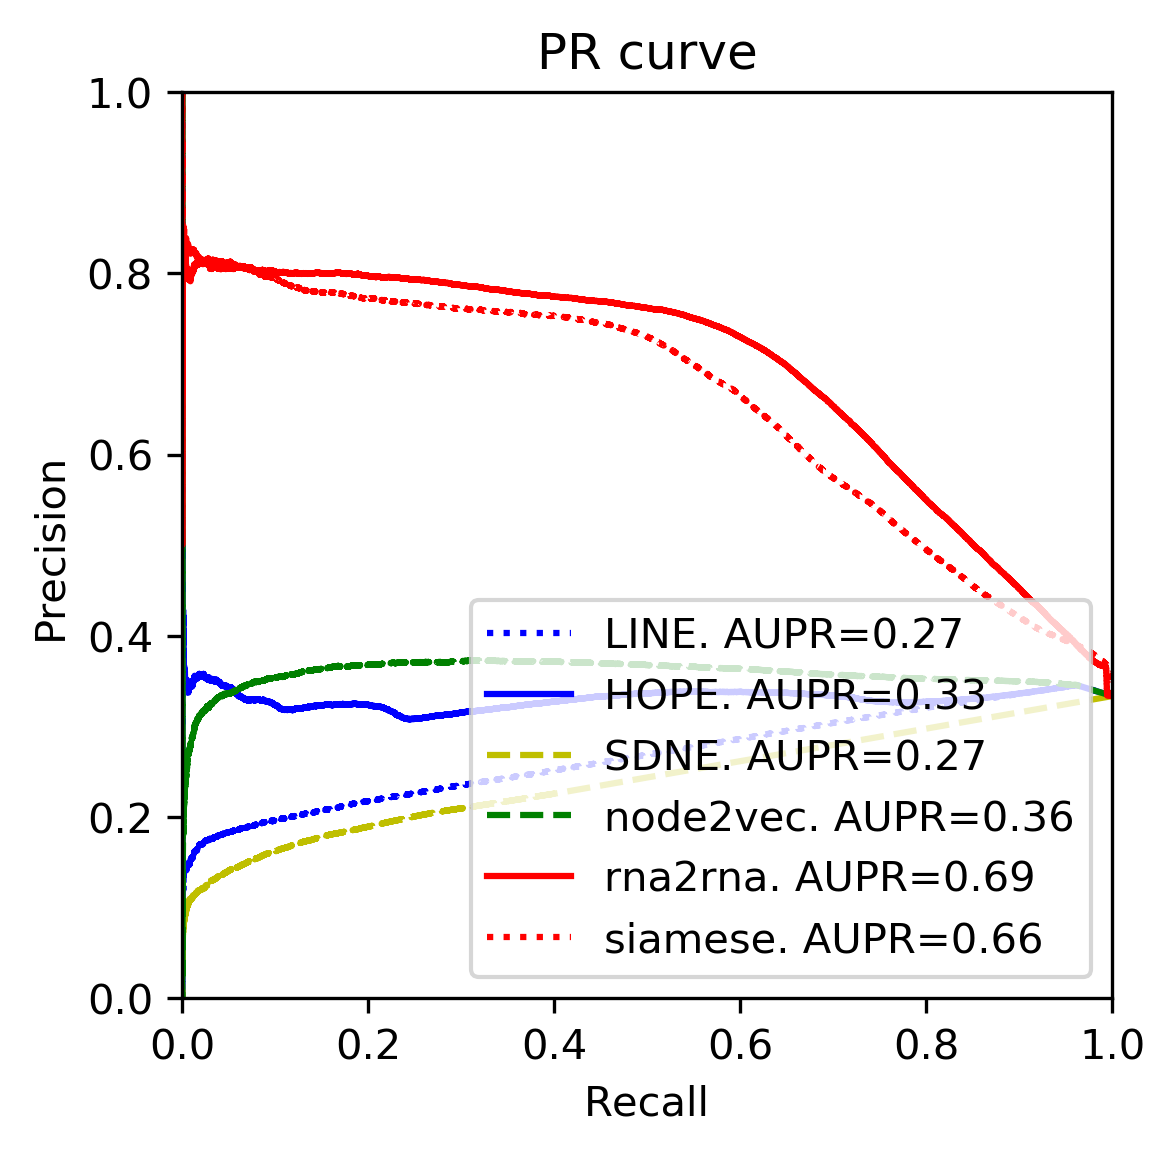

In [98]:
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score ,precision_recall_curve

fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_dict = {"LINE":"b", "HOPE":"b", "SDNE":"y", "node2vec":"g", "rna2rna":"r", "siamese":"r"}
ls_dict = {"LINE":":", "HOPE":"-", "SDNE":"--", "node2vec":"--", "rna2rna":"-", "siamese":":"}

for method in y_pred_dict.keys():
    y_prob_pred = y_pred_dict[method]
    average_precision = average_precision_score(y_true=y_true, y_score=y_prob_pred)
    precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=y_prob_pred, pos_label=1)

    ax.plot(recall, precision, color=color_dict[method], ls=ls_dict[method],
             label=method+'. AUPR={0:0.2f}'.format(average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.00])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('PR curve')
plt.show()

Method: node2vec
Method: LINE
Method: HOPE
Method: SDNE
Method: rna2rna
Method: siamese


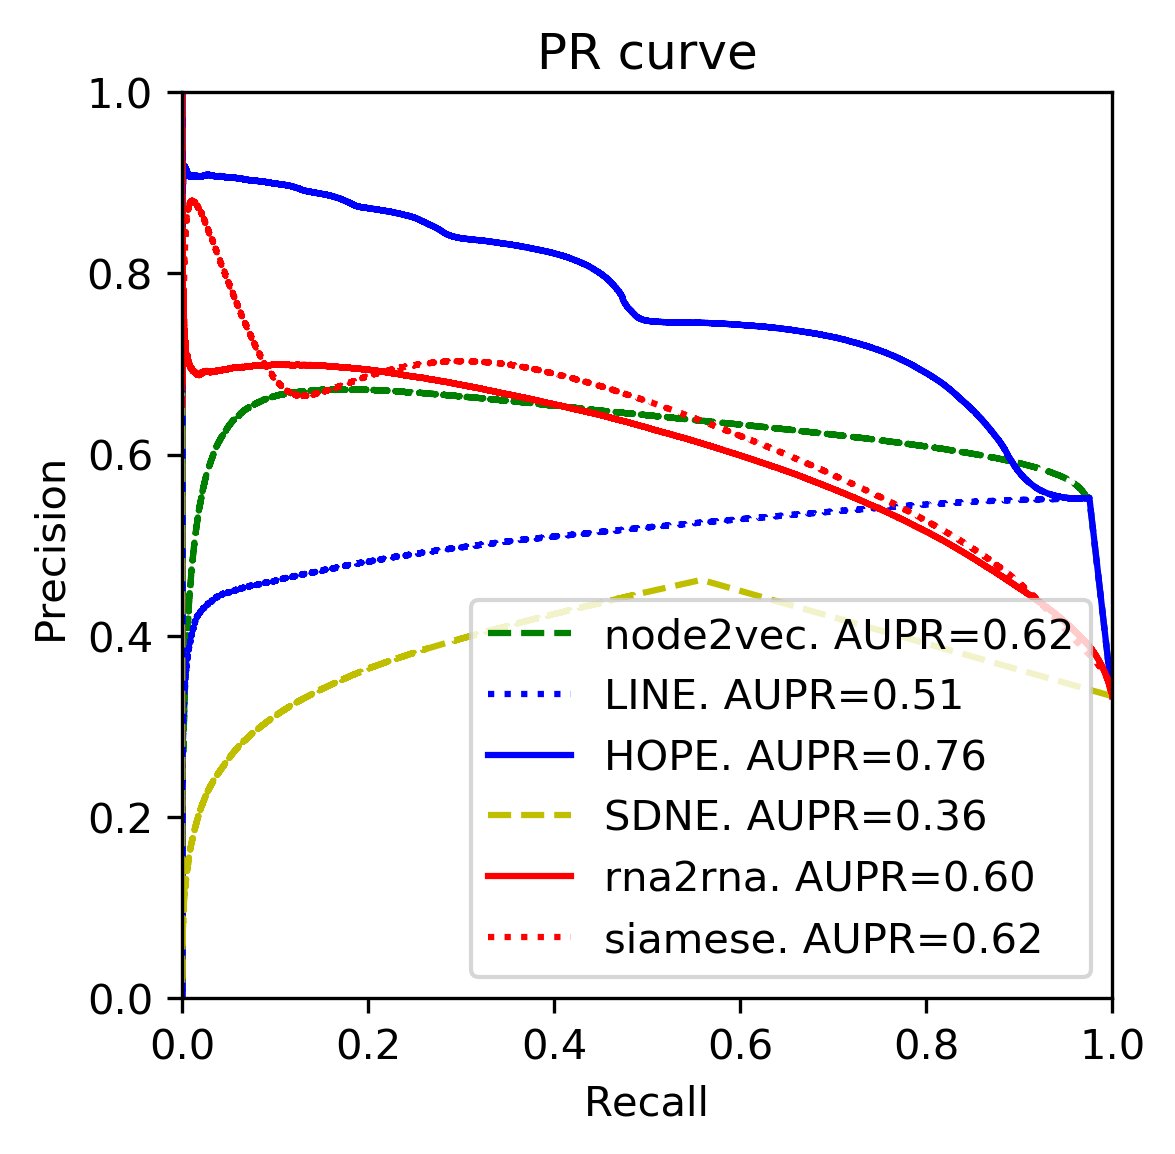

In [18]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred
evaluate_pr_curve_link_pred(methods, X, y_true)

# Top-K Link Prediction

In [90]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

for method in methods.keys():
    print(method)
    print(evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                         node_list=methods[method].node_list, edge_type="d", top_k=10000))

node2vec
{'precision': 0.0, 'recall': 0.0}
LINE
{'precision': 0.0, 'recall': 0.0}
HOPE
{'precision': 0.0011, 'recall': 0.00012853470437017994}
SDNE
{'precision': 0.0, 'recall': 0.0}
rna2rna
{'precision': 0.0022, 'recall': 0.0002484584283875048}
siamese
{'precision': 0.0041, 'recall': 0.00046234691806310474}


In [22]:
from moge.evaluation.node_clustering import evaluate_clustering

for method in methods.keys():
    print(method)
    print(evaluate_clustering(methods[method], network=network, node_label="Family", 
                              max_clusters=500, n_clusters=None))

node2vec
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.480904139800322, 'completeness': 0.5295207614847134, 'nmi': 0.5040428556033429}
LINE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.49540835850769643, 'completeness': 0.5354935868926516, 'nmi': 0.5146716427445739}
HOPE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.3937922026177057, 'completeness': 0.49865213703484856, 'nmi': 0.44006178236152593}
SDNE
Clustering 12838 nodes with n_clusters: 500
{'homogeneity': 0.36178470401371227, 'completeness': 0.4785748569852502, 'nmi': 0.41206424254159746}
rna2rna
Clustering 14254 nodes with n_clusters: 500
{'homogeneity': 0.4749790915650755, 'completeness': 0.516377033124781, 'nmi': 0.49481369608809145}
siamese
Clustering 14254 nodes with n_clusters: 500
{'homogeneity': 0.48271917519578955, 'completeness': 0.5365420130982343, 'nmi': 0.508209516844578}


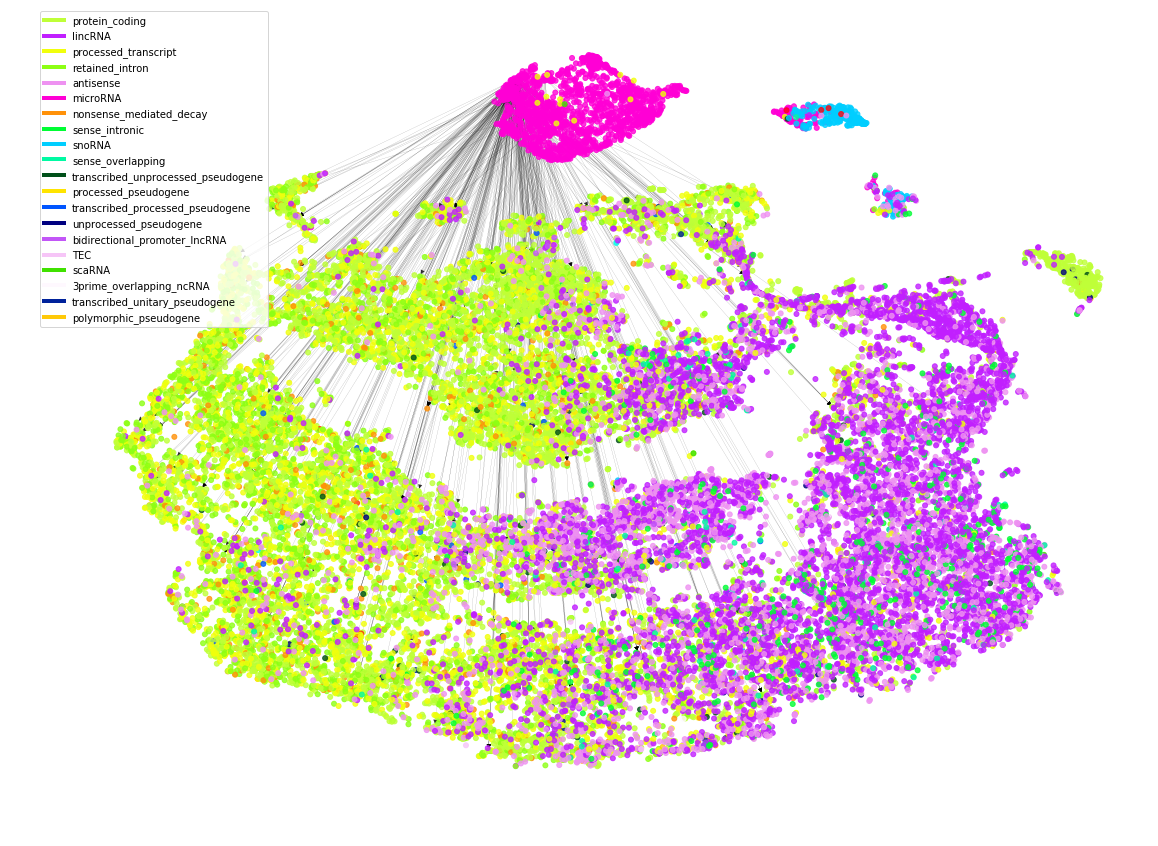

In [20]:
from moge.visualization.visualize_embedding import visualize_embedding
visualize_embedding(siamese, network=network, node_label="locus_type", 
                    edgelist=network_val.get_edgelist(node_list=network.node_list, edge_types=["d"])[:500],
#                     test_nodes=node_list,
                    cmap="gist_ncar",)

In [69]:
from moge.evaluation.node_classification import evaluate_classification

for method in methods.keys():
    print()
    print(method)
    print([(k, np.average(v)) for k,v in evaluate_classification(methods[method], network, cv=5,
                                  node_label="Disease association", multilabel=False,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()])


node2vec
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 1.0402504920959472), ('score_time', 0.014069414138793946), ('test_precision_macro', 0.01682355093978935), ('test_recall_macro', 0.020475074340268067), ('test_f1_macro', 0.017693030747362733)]

LINE
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 1.634997510910034), ('score_time', 0.022185516357421876), ('test_precision_macro', 0.025895864037130456), ('test_recall_macro', 0.02648393484470976), ('test_f1_macro', 0.025147635048809597)]

HOPE
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 7.644103765487671), ('score_time', 0.022169780731201173), ('test_precision_macro', 0.02084197525578419), ('test_recall_macro', 0.02975567653922484), ('test_f1_macro', 0.02214796457191798)]

SDNE
# of labels with >cv samples: 105 , # of nodes to train/test: 1762


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 7.233033847808838), ('score_time', 0.022505569458007812), ('test_precision_macro', 0.011412630296538695), ('test_recall_macro', 0.013913085246535834), ('test_f1_macro', 0.00811258460044705)]

rna2rna
# of labels with >cv samples: 105 , # of nodes to train/test: 1927


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 1.6198489665985107), ('score_time', 0.0338071346282959), ('test_precision_macro', 0.0112722743939813), ('test_recall_macro', 0.02474744553691922), ('test_f1_macro', 0.013817796909481317)]

siamese
# of labels with >cv samples: 105 , # of nodes to train/test: 1945
[('fit_time', 1.197097110748291), ('score_time', 0.03889288902282715), ('test_precision_macro', 0.021497003538884712), ('test_recall_macro', 0.03327806696227749), ('test_f1_macro', 0.02234096124390922)]


In [83]:
for method in methods.keys():
    print("\n", method)
    print(methods[method].get_scalefree_fit_score(methods[method].node_list))
    # for A, B in [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]:
    #    print(A, B, methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B]))


 node2vec
0.6724540085123913

 LINE
0.759433706490722

 HOPE
0.8708130546069005

 SDNE
0.7160512673762639

 rna2rna
0.13997429868479735

 siamese
0.2420722230304487


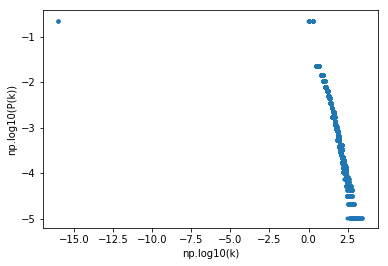

0.8423381196737936

In [64]:
from moge.evaluation.utils import get_scalefree_fit_score
adj = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)
network_degrees = np.sum(adj, axis=1)
get_scalefree_fit_score(network_degrees, plot=True)

# AUC Rate

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>